<a href="https://colab.research.google.com/github/RuwanthiLakshika/Image-Classifier/blob/main/Cat_Dog_Classifier_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy -q
!pip install pandas -q
!pip install matplotlib -q
!pip install tensorflow -q

!pip install opendatasets -q

In [2]:
# import necessary libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

import opendatasets as od

In [4]:
od.download('https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ruwanthilakshik
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dineshpiyasamara/cats-and-dogs-for-classification


100%|██████████| 217M/217M [00:06<00:00, 34.2MB/s]


In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = (128,128)

In [6]:
train_data_dir='/content/cats-and-dogs-for-classification/cats_dogs/train'
test_data_dir='/content/cats-and-dogs-for-classification/cats_dogs/test'

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='training',
                                                         validation_split=0.1,
                                                         seed=42)

validation_data = tf.keras.utils.image_dataset_from_directory(train_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE,
                                                         subset='validation',
                                                         validation_split=0.1,
                                                         seed=42)

test_data = tf.keras.utils.image_dataset_from_directory(test_data_dir,
                                                         batch_size=BATCH_SIZE,
                                                         image_size=IMAGE_SIZE)

Found 8000 files belonging to 2 classes.
Using 7200 files for training.
Found 8000 files belonging to 2 classes.
Using 800 files for validation.
Found 2000 files belonging to 2 classes.


In [8]:
class_names = train_data.class_names
class_names

['cats', 'dogs']

In [9]:
for image_batch,label_batch in train_data.take(1):
  print(image_batch.shape)
  print(label_batch.shape)

(32, 128, 128, 3)
(32,)


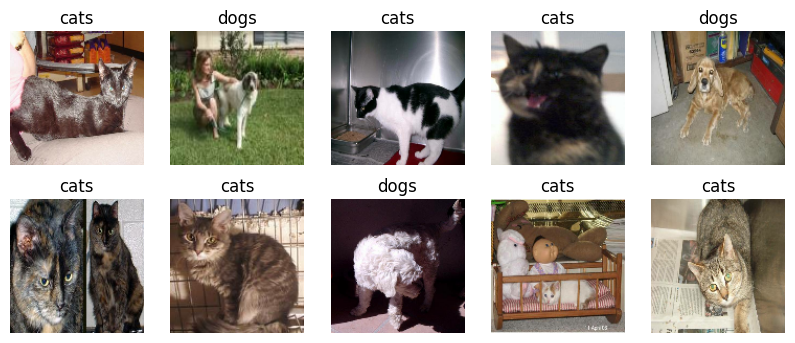

In [10]:
# plot data sample
plt.figure(figsize=(10,4))
for image,label in train_data.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

## Feature Scaling

In [12]:
train_data = train_data.map(lambda x,y:(x/255,y))
validation_data = validation_data.map(lambda x,y:(x/255,y))
test_data = test_data.map(lambda x,y:(x/255,y))

## Transfer Learning

In [13]:
pretrained_model = tf.keras.applications.xception.Xception(include_top=False,
                                                           input_shape=(128,128,3),
                                                           weights="imagenet",
                                                           pooling='max')

for layer in pretrained_model.layers:
        layer.trainable=False

83683744/83683744 [==============================] - 2s 0us/step


## Model Building

In [14]:
model = tf.keras.models.Sequential()

model.add(pretrained_model)

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21144425 (80.66 MB)
Trainable params: 2829

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## Model Training

In [17]:
start_time = time.time()

history = model.fit(train_data,
                    epochs=3,
                    validation_data=validation_data)

end_time = time.time()

Epoch 1/3
225/225 [==============================] - 22s 62ms/step - loss: 0.1658 - accuracy: 0.9306 - val_loss: 0.1477 - val_accuracy: 0.9438
Epoch 2/3
225/225 [==============================] - 12s 53ms/step - loss: 0.1122 - accuracy: 0.9544 - val_loss: 0.1061 - val_accuracy: 0.9563
Epoch 3/3
225/225 [==============================] - 12s 52ms/step - loss: 0.0962 - accuracy: 0.9611 - val_loss: 0.1117 - val_accuracy: 0.9625


## Perfomance Analysis

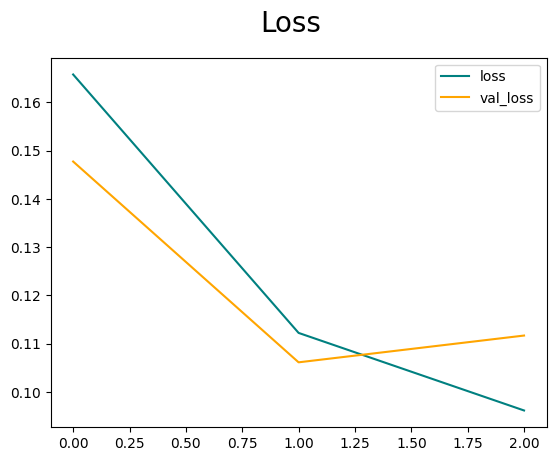

In [18]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()


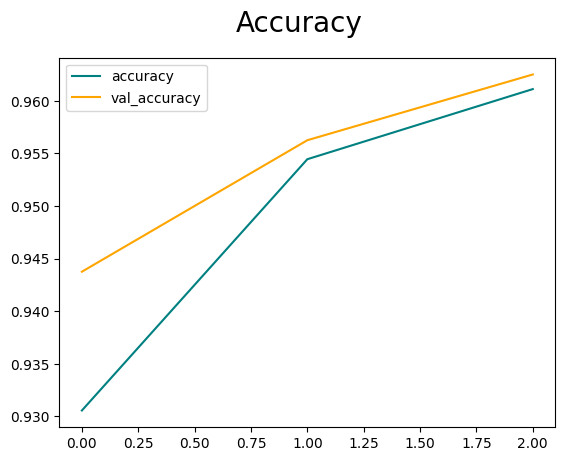

In [19]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()

## Model Evaluation

In [20]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()


In [21]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 2s 2s/step


In [22]:
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9748164>

In [23]:
recall.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.929>

In [24]:
accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9525>

## Test

In [25]:

!pip install opencv-python -q

In [26]:
import cv2

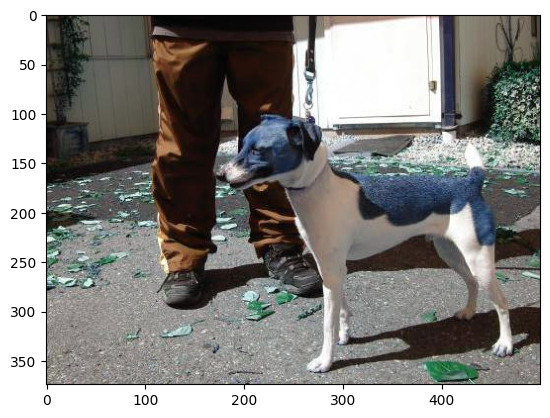

In [35]:
image=cv2.imread('/content/cats-and-dogs-for-classification/cats_dogs/test/dogs/dog.4023.jpg')
plt.imshow(image)
plt.show()

In [36]:
resized_image = tf.image.resize(image, IMAGE_SIZE)
scaled_image = resized_image/255

In [37]:
yhat = model.predict(np.expand_dims(scaled_image, 0))


1/1 [==============================] - 0s 135ms/step


In [38]:
yhat

array([[0.950155]], dtype=float32)

In [ ]:
class_names

['cats', 'dogs']

In [39]:
if yhat > 0.5:
    print(f'{class_names[1]}')
else:
    print(f'{class_names[0]}')

dogs
